In [3]:
import os

# Introduction

As a study project following the read of *deep learning with keras* book by f.chollet, I've come up with the idea of using transfer learning with semi-automatic annotated datasets. In particular, gathering positions of landmarks within a city which their position is already known and annotated and then extracting their image representation. 

I've think that  *soccer stadiums* could be a good fit for this idea because stadiums possibly stand-out from the city-scape in terms of size, color and shape. 

I know finding stadiums automatically does not add any real-world value but the purpose of this project is 
to gain insights and xp on extracting value from satellite images and leveraging ML to do so.




* I've collected satellite images for a few cities in Argentina, at different zoom levels. They're stored in tiles format, very much like how google maps/openstreetmaps. Each image is 256x256 px , covering a square area in the city.
* I've a dataset containing the lat,lng coords of most important soccer stadiums in Argentina, some within the cities from the sattelite images
* Hypotheses: We can match lat,lng coordinates of stadiums to their corresponding satellite image and use that to train a classifier capable of detecting stadiums within a city satellite map.

## Reading tile images

tiles are in zoom/x/y.jpg format

In [5]:
xs = os.listdir('tiles/17/',)

In [6]:
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk('tiles/17/'):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))

In [7]:
files[0:10]

['tiles/17/44134/52033.jpg',
 'tiles/17/44134/52034.jpg',
 'tiles/17/44134/52035.jpg',
 'tiles/17/44134/52036.jpg',
 'tiles/17/44134/52037.jpg',
 'tiles/17/44134/52038.jpg',
 'tiles/17/44134/52039.jpg',
 'tiles/17/44134/52040.jpg',
 'tiles/17/44134/52041.jpg',
 'tiles/17/44134/52042.jpg']

this utility functions convert from (lat,lng) <-> (zoom,x,y) coordinate

In [8]:
import math
def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xoffset = (lon_deg + 180.0) / 360.0 * n
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    yoffset = (1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n
    
    return  (xoffset,yoffset)
import math
def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

Let's try out with a sample coordinate to test out above translation. Check if translated coords have a coresponding image in our dataset.

In [11]:
sample_stadium_location = {'lat': -34.5453062, 'lng': -58.44977489999999}
deg2num(-sample_stadium_location['lat'],sample_stadium_location['lng'],17)


(44255.08640085334, 52118.87558031961)

In [12]:
'tiles/17/44255/52118.jpg' in files

True

Now let's try with a real stadium coordinate, check out that it renders a valid stadium image. 

In [15]:
# load stadium coordinates from xml files

from lxml import etree
from io import StringIO, BytesIO

root = etree.parse('../mapaestadios.xml')
lats = list(root.xpath('//marker/@lat'))
lngs = list(root.xpath('//marker/@lng'))
names = list(root.xpath('//marker/@name'))

stadium_coords = list(zip(names,zip(lats,lngs)))[1:]

In [16]:
sample_coords = stadium_coords[0][1]

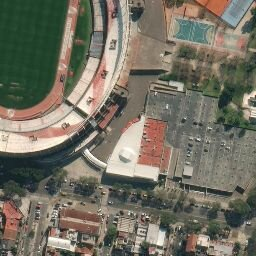

In [17]:
from IPython.display import Image
from IPython.core.display import HTML 

#try loading a sample stadium 
def get_stadium_image(lat,lng,zoom):
    x,y = deg2num(-lat,lng,zoom)
    filename = 'tiles/%s/%s/%s.jpg' % (zoom,int(x),int(y))
    if filename in files:
        return './'+filename
    return None
sample_image = get_stadium_image(float(sample_coords[0]),float(sample_coords[1]),17)
Image(sample_image)

because of the zoom level, a stadium can be splitted amongst many tiles, this will damage our training.
We'll generate images centered on the stadium so that it fits one tile and use these for training.

In [18]:
import math
def offset_in_image(lat,lng,zoom): 
    offset = (256 << (zoom-1)) - (256 << (zoom-1))/math.pi * math.log((1 + math.sin(lat * math.pi / 180)) / (1 - math.sin(lat * math.pi / 180))) / 2;
    circley = offset - 256*y;
    
def lonToX(lon, zoom):
    offset = 256 << (zoom-1);
    return round(offset + (offset * lon / 180));

def latToY(lat,zoom):
    offset = 256 << (zoom-1);
    return round(offset - offset/math.pi * math.log((1 + math.sin(lat * math.pi / 180)) / (1 - math.sin(lat * math.pi / 180))) / 2);


we'll build a mosaic with the 9 tiles surrounding a given coordinate in all directions. Then, extract an image from this mosaic with the stadium coordinates in the middle. 

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np


def make_9_mosaic(x,y,zoom):
    w, h = 256*3, 256*3
    data = np.zeros((h, w, 3), dtype=np.uint8)
    
    mosaic_files = ['tiles/%s/%s/%s.jpg' % (zoom,int(r),int(s)) for r in [x-1,x,x+1] for s in [y+1,y,y-1]]
    if any(map(lambda x: x not in files,mosaic_files)):
        return None
    
    
    result = Image.new('RGB', (w, h))
    for i in range(0,9):
        box = (int(i/3)*256,i%3*256)
        result.paste(im=Image.open(mosaic_files[i]), box=box)    
    
    return result


    
def get_centered_image(lat,lng,zoom):
    x,y = deg2num(-lat,lng,zoom)
    result = make_9_mosaic(x,y,zoom)
    if result:
        offset_x = 256+int((float(x) - int(x))*256)
        offset_y = 256+int(256 - (float(y)-int(y))*256)
        bound_box=(offset_x-127,offset_y-127,offset_x+128,offset_y+128)
        centered_image = result.crop(bound_box)
        return centered_image
    return None
    

let's try getting some centered images

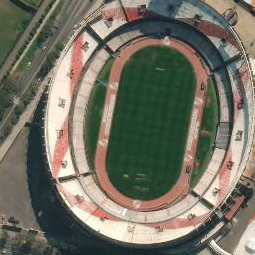

In [20]:
get_centered_image(float(sample_coords[0]),float(sample_coords[1]),17)

that's better, now let's get images for all stadiums. Some may not be within Buenos Aires bounding box. 

In [21]:
stadium_images = []
for s in stadium_coords:
    if s[1][0]!="" and s[1][1]!="":
        lat = float(s[1][0])
        lon = float(s[1][1])
        file = get_stadium_image(float(s[1][0]),float(s[1][1]),17)
        if file:
            x_offset,y_offset = deg2num(float(s[1][0]),float(s[1][1]),17)
            centered_image = get_centered_image(lat,lon,17)
            if centered_image:
                centered_image.save('stadiums/'+s[0]+'.png',format='png')
                print('%s saved ok' % s[0])
        else:
            print("%s not found" % s[0])

Estadio Monumental Antonio Vespucio Liberti saved ok
Estadio Mario Alberto Kempes not found
Estadio Presidente Perón saved ok
Estadio José Amalfitani saved ok
Estadio Alberto J. Armando saved ok
Estadio Tomás Adolfo Ducó saved ok
Estadio Ciudad de Lanús - Néstor Díaz Pérez saved ok
Estadio Malvinas Argentinas not found
Estadio Libertadores de América saved ok
Estadio Pedro Bidegain saved ok
Estadio Marcelo Bielsa not found
Estadio Gigante de Arroyito not found
Estadio Brigadier General Estanislao López not found
Estadio Ciudad de La Plata not found
Estadio Eduardo Gallardón not found
Estadio José María Minella not found
Estadio Florencio Sola not found
Estadio Monumental José Fierro not found
Estadio Juan Domingo Perón not found
Estadio Nueva España saved ok
Estadio Nuevo Francisco Urbano saved ok
Estadio Ciudad de Vicente López saved ok
Estadio San Juan del Bicentenario not found
Estadio Centenario Ciudad de Quilmes not found
Estadio Julio Cesar Villagra not found
Estadio República de

We sample images from the rest of the dataset (avoiding images from stadiums) as negative samples for our classifier.

In [22]:
stadium_images = []
for s in stadium_coords:
    zoom=17
    if s[1][0]!="" and s[1][1]!="":
        lat = float(s[1][0])
        lon = float(s[1][1])
        x,y = deg2num(-lat,lon,zoom)
        surround_files = ['tiles/%s/%s/%s.jpg' % (zoom,int(r),int(s)) for r in [x-1,x,x+1] for s in [y+1,y,y-1]]
        stadium_images+=surround_files


In [23]:
import random
non_stadium_images = set(files) - set(stadium_images)
non_stadium_samples = random.sample(non_stadium_images,len(stadium_images)*10)


see sample image non_stadium

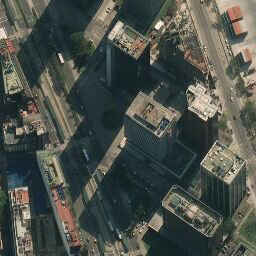

In [24]:
from PIL import Image
Image.open(non_stadium_samples[10])

In [115]:
# copy images to non_stadium folder
for image in non_stadium_samples:
    filename = "_".join(image.split('/')[-3:])
    img = Image.open(image)
    img.save('non_stadiums/'+filename)